<a href="https://colab.research.google.com/github/mehdii190/neural-network/blob/main/src/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms , models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
def get_image(path , img_transform , size = (300,300)):
  image = Image.open(path)
  image = image.resize(size,Image.LANCZOS)
  image = img_transform(image).unsqueeze(0)
  return image.to(device)

def get_gram(m):
  """
  m is of shape
  """
  _,c , h , w = m.size()
  m = m.view(c, h*w)
  m = torch.mm(m , m.t())
  return m

def denormalize_img(inp):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = inp*std+mean
  inp = np.clip(inp,0,1)
  return inp


In [52]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.selected_layers = [3,8,15,22]
    self.vgg = models.vgg16(pretrained = True).features


  def forward(self, x):
    layer_feats = []
    for layer_num , layer in self.vgg._modules.items():
      x = layer(x)
      if int(layer_num) in self.selected_layers:
        layer_feats.append(x)
    return layer_feats

In [53]:



img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean =(0.485,0.456,0.406),std =(0.229,0.224,0.225)) ])



content_img = get_image("/content/AnyConv.com__1678459625198.jpg", img_transform)
style_img = get_image("/content/picasso_selfport1907.jpg", img_transform)
generated_img = content_img.clone()
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr= 0.003, betas =[0.5,0.0999])

encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
  p.requires_grad = False



In [54]:
content_weight = 1
style_weight = 100



for epoch in range(500):

  content_features =encoder(content_img)
  style_features =encoder(style_img)
  generated_features =encoder(generated_img)

  content_loss = torch.mean((content_features[-1]- generated_features[-1])**2)

  style_loss = 0

  for gf , sf in zip(generated_features, style_features):
    _, c , h, w = gf.size()
    gram_gf = get_gram(gf)
    gram_sf = get_gram(sf)
    style_loss = torch.mean((gram_gf - gram_sf)**2)/ (c * h * w)

  loss = content_weight * content_loss + style_weight * style_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:

     print("epoch [{}]\tcontent loss: {:.4f}".format(epoch,content_loss.item(),style_loss.item()))






epoch [0]	content loss: 0.0000
epoch [10]	content loss: 0.9521
epoch [20]	content loss: 1.6937
epoch [30]	content loss: 2.0667
epoch [40]	content loss: 2.2643
epoch [50]	content loss: 2.3291
epoch [60]	content loss: 2.3430
epoch [70]	content loss: 2.3992
epoch [80]	content loss: 2.4314
epoch [90]	content loss: 2.4165
epoch [100]	content loss: 2.4593
epoch [110]	content loss: 2.4539
epoch [120]	content loss: 2.4659
epoch [130]	content loss: 2.4661
epoch [140]	content loss: 2.4938
epoch [150]	content loss: 2.4871
epoch [160]	content loss: 2.4788
epoch [170]	content loss: 2.4811
epoch [180]	content loss: 2.4906
epoch [190]	content loss: 2.5219
epoch [200]	content loss: 2.5003
epoch [210]	content loss: 2.4901
epoch [220]	content loss: 2.5437
epoch [230]	content loss: 2.5023
epoch [240]	content loss: 2.5330
epoch [250]	content loss: 2.5225
epoch [260]	content loss: 2.5196
epoch [270]	content loss: 2.5255
epoch [280]	content loss: 2.5424
epoch [290]	content loss: 2.5007
epoch [300]	content l

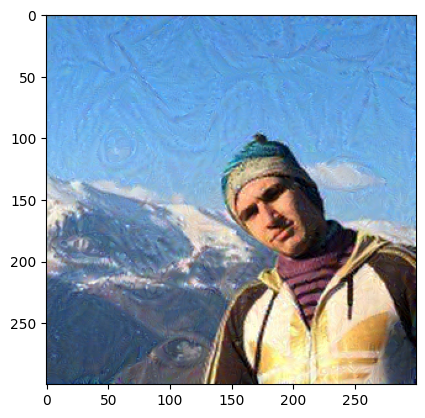

In [55]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)

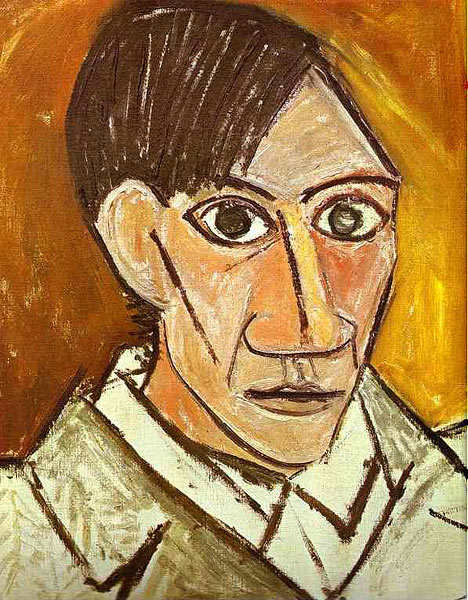

In [56]:
Image.open("/content/picasso_selfport1907.jpg")